In [5]:
%matplotlib widget

# Text Answers

Here are my text answers for part A.  To see the code I wrote and modified, as well as the time and costs graphs, scroll down to the very bottom.

## Response
As for the lowest cost, because of the way the algorithms search for a path at the end of the program, all algorithms tested except for the A* algorithm that we wrote returns a minimum cost.

However, our A* found paths faster than any other algorithm.

Looking at our algorithm I would definitely change the method in which we find our path from goal to start.  Currently we just follow the previous node's parent, whereas many of the other algorithms check for a minimum at each node's predecessor.

The best planner overall would be a Bidirectional A Star.  For extreme examples the bidirectional A star still reigns supreme for finding solutions to complex solutions in minimal time, especially compared to algorithms like the BFS.
Although, if the problem sizes are small enough, I would opt for a Dikstras or BFS simply for their speed and relyability.

I find the best overall to be the Bidirectoinal Astar, and the one I would implement for our robot would be either Bidirection Astar or Dikstras.

# Part A Part 1

Below I implemented my own a Star algorithm, for demonstration and visual.  The original a star before being modified for the rest of the test set is below

```python
def astar(maze, sx, sy, gx, gy) -> list[tuple]:

    start_node = self.Node(
        self.calc_xy_index(sx, self.min_x),
        self.calc_xy_index(sy, self.min_y),
        0.0,
        -1,
    )
    goal_node = self.Node(
        self.calc_xy_index(gx, self.min_x),
        self.calc_xy_index(gy, self.min_y),
        0.0,
        -1,
    )

    open_list: "list[Node]" = []
    close_list: "list[Node]" = []

    open_list.append(start_node)

    while open_list:

        # Find minimum f value in open list
        c_node = open_list[0]
        c_idx = 0
        for idx, item in enumerate(open_list):
            if item.f < c_node.f:
                c_node = item
                c_idx = idx

        # Clost lowest F
        close_list.append(open_list.pop(c_idx))

        # If end node is reached
        if c_node == goal_node:
            path = []

            c = c_node
            while c is not None:
                path.append(c.position)
                c = c.parent

            return path[::-1]

        # Generate children
        children = []
        for new_position in [
            (0, -1),
            (0, 1),
            (-1, 0),
            (1, 0),
            (-1, -1),
            (-1, 1),
            (1, -1),
            (1, 1),
        ]:  # Adjacent squares

            # Get node position
            node_position = (
                c_node.position[0] + new_position[0],
                c_node.position[1] + new_position[1],
            )

            # Make sure within range
            if (
                node_position[0] > (len(maze) - 1)
                or node_position[0] < 0
                or node_position[1] > (len(maze[len(maze) - 1]) - 1)
                or node_position[1] < 0
            ):
                continue

            # Make sure walkable terrain
            if maze[node_position[0]][node_position[1]] != 0:
                continue

            # Create new node
            new_node = Node(c_node, node_position)

            # Append
            children.append(new_node)

        for child in children:
            if child in close_list:
                continue

            # Create the f, g, and h values
            child.g = c_node.g + 1
            child.h = ((child.position[0] - goal_node.position[0]) ** 2) + (
                (child.position[1] - goal_node.position[1]) ** 2
            )
            child.f = child.g + child.h

            # Child is already in the open list
            for open_node in open_list:
                if child == open_node and child.g > open_node.g:
                    continue

            # Add the child to the open list
            open_list.append(child)

```

In [6]:
# Below is my implelmentation of A star
import math
show_animation = False


class MyAStarPlanner:
    def __init__(self, ox: list, oy: list, resolution: list, rr):
        """
        Initialize grid map for a star planning

        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.resolution = resolution
        self.rr = rr
        self.min_x, self.min_y = 0, 0
        self.max_x, self.max_y = 0, 0
        self.obstacle_map = None
        self.x_width, self.y_width = 0, 0
        self.motion = self.get_motion_model()
        self.calc_obstacle_map(ox, oy)

    class Node:
        """A node class for A* Pathfinding"""

        def __init__(self, parent, position: "tuple[int,int]"):
            self.parent = parent
            self.position = position

            self.f = 0
            self.g = 0
            self.h = 0

        def __eq__(self, other):
            return self.position == other.position

        def __hash__(self):
            return hash(self.position)

        def __str__(self):
            return self.position

    # this is my planning algorithm modified to take input in the same format
    def planning(self, sx, sy, gx, gy) -> list[tuple]:
        start_node = self.Node(
            None,
            (self.calc_xy_index(sx, self.min_x), self.calc_xy_index(sy, self.min_y)),
        )
        goal_node = self.Node(
            None,
            (self.calc_xy_index(gx, self.min_x), self.calc_xy_index(gy, self.min_y)),
        )

        open_set: "list[Node]" = dict()
        close_set: "list[Node]" = dict()

        # Move to a set because the in operator doesn't like us
        open_set[self.calc_grid_index(start_node)] = start_node

        while open_set:

            # Find minimum f value in open list
            current_id = min(
                open_set,
                key=lambda x: open_set[x].f
                + self.calc_heuristic(open_set[x], goal_node),
            )
            
            current_node = open_set[current_id]
            # If end node is reached
            if current_node == goal_node:
                goal_node.parent = current_node
                goal_node.f = current_node.f
                break
            

            # Clost lowest F
            del open_set[current_id]
            close_set[current_id] = current_node

            # Generate children
            children: list[Node] = []
            for i, _ in enumerate(self.motion):  # Adjacent squares
                # Get node position
                n_node = self.Node(
                    current_node,
                    (
                        current_node.position[0] + self.motion[i][0],
                        current_node.position[1] + self.motion[i][1],
                    ),
                )
                n_node.g = self.motion[i][2]
                n_id = self.calc_grid_index(n_node)
                
                # Make sure within range
                if not self.verify_node(n_node):
                    continue
                
                if n_id in close_set:
                    continue
                
                children.append(n_node)

            for child in children:
                # Create the f, g, and h value
                child.h = self.calc_heuristic(child, goal_node)
                child.f = child.g + child.h
                
                child_id = self.calc_grid_index(child)
                
                if child_id not in open_set:
                    open_set[child_id] = child
                else:
                    if open_set[child_id].f > child.f:
                        # Override node if cheaper one is found
                        open_set[child_id] = child
                    
                

        rx, ry, cost = self.calc_final_path(goal_node, close_set)
        return rx, ry, cost

    def calc_final_path(self, goal_node: "Node", closed_set: dict):
        cost = 0
        # generate final course
        rx, ry = [self.calc_grid_position(goal_node.position[0], self.min_x)], [
            self.calc_grid_position(goal_node.position[1], self.min_y)
        ]
        n = goal_node

        while n is not None:
            cost += 1
            rx.append(self.calc_grid_position(n.position[0], self.min_x))
            ry.append(self.calc_grid_position(n.position[1], self.min_y))
            n = n.parent            
        return rx, ry, cost

    @staticmethod
    def calc_heuristic(n1: Node, n2: Node):
        return ((n1.position[0] - n2.position[0]) ** 2) + (
            (n1.position[1] - n2.position[1]) ** 2
        )

    def calc_grid_position(self, index, min_position):
        """
        calc grid position

        :param index:
        :param min_position:
        :return:
        """
        pos = index * self.resolution + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        return round((position - min_pos) / self.resolution)

    def calc_grid_index(self, node: Node):
        return (node.position[1] - self.min_y) * self.x_width + (node.position[0] - self.min_x)

    def verify_node(self, node):
        px = self.calc_grid_position(node.position[0], self.min_x)
        py = self.calc_grid_position(node.position[1], self.min_y)

        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False

        # collision check
        if self.obstacle_map[node.position[0]][node.position[1]]:
            return False

        return True

    def calc_obstacle_map(self, ox, oy):

        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))

        self.x_width = round((self.max_x - self.min_x) / self.resolution)
        self.y_width = round((self.max_y - self.min_y) / self.resolution)

        # obstacle map generation
        self.obstacle_map = [
            [False for _ in range(self.y_width)] for _ in range(self.x_width)
        ]
        for ix in range(self.x_width):
            x = self.calc_grid_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_grid_position(iy, self.min_y)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obstacle_map[ix][iy] = True
                        break

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [
            [1, 0, 1],
            [0, 1, 1],
            [-1, 0, 1],
            [0, -1, 1],
            [-1, -1, math.sqrt(2)],
            [-1, 1, math.sqrt(2)],
            [1, -1, math.sqrt(2)],
            [1, 1, math.sqrt(2)],
        ]

        return motion


# Part A Part 2: Timing Study

In [7]:
# Planners below, all slightly modified to fit the correct resolution

import math
import random
import numpy as np
import matplotlib.pyplot as plt

show_animation = True


class AStarPlanner:
    def __init__(self, ox: list, oy: list, resolution: list, rr):
        """
        Initialize grid map for a star planning

        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.resolution = resolution
        self.rr = rr
        self.min_x, self.min_y = 0, 0
        self.max_x, self.max_y = 0, 0
        self.obstacle_map = None
        self.x_width, self.y_width = 0, 0
        self.motion = self.get_motion_model()
        self.calc_obstacle_map(ox, oy)

    class Node:
        def __init__(self, x, y, cost, parent_index):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.cost = cost
            self.parent_index = parent_index

        def __str__(self):
            return (
                str(self.x)
                + ","
                + str(self.y)
                + ","
                + str(self.cost)
                + ","
                + str(self.parent_index)
            )

    def planning(self, sx, sy, gx, gy):
        """
        A star path search

        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]

        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        start_node = self.Node(
            self.calc_xy_index(sx, self.min_x),
            self.calc_xy_index(sy, self.min_y),
            0.0,
            -1,
        )
        goal_node = self.Node(
            self.calc_xy_index(gx, self.min_x),
            self.calc_xy_index(gy, self.min_y),
            0.0,
            -1,
        )

        open_set, closed_set = dict(), dict()
        open_set[self.calc_grid_index(start_node)] = start_node

        while 1:
            if len(open_set) == 0:
                print("Open set is empty..")
                break

            c_id = min(
                open_set,
                key=lambda o: open_set[o].cost
                + self.calc_heuristic(goal_node, open_set[o]),
            )
            current = open_set[c_id]

            if current.x == goal_node.x and current.y == goal_node.y:
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Remove the item from the open set
            del open_set[c_id]

            # Add it to the closed set
            closed_set[c_id] = current

            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):
                node = self.Node(
                    current.x + self.motion[i][0],
                    current.y + self.motion[i][1],
                    current.cost + self.motion[i][2],
                    c_id,
                )
                n_id = self.calc_grid_index(node)

                # If the node is not safe, do nothing
                if not self.verify_node(node):
                    continue

                if n_id in closed_set:
                    continue

                if n_id not in open_set:
                    open_set[n_id] = node  # discovered a new node
                else:
                    if open_set[n_id].cost > node.cost:
                        # This path is the best until now. record it
                        open_set[n_id] = node

        rx, ry, cost = self.calc_final_path(goal_node, closed_set)

        return rx, ry, cost

    def calc_final_path(self, goal_node, closed_set):
        cost = 0
        # generate final course
        rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [
            self.calc_grid_position(goal_node.y, self.min_y)
        ]
        parent_index = goal_node.parent_index
        while parent_index != -1:
            cost += 1
            n = closed_set[parent_index]
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            parent_index = n.parent_index

        return rx, ry, cost

    @staticmethod
    def calc_heuristic(n1, n2):
        w = 1.0  # weight of heuristic
        d = w * math.hypot(n1.x - n2.x, n1.y - n2.y)
        return d

    def calc_grid_position(self, index, min_position):
        """
        calc grid position

        :param index:
        :param min_position:
        :return:
        """
        pos = index * self.resolution + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        return round((position - min_pos) / self.resolution)

    def calc_grid_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def verify_node(self, node):
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)

        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False

        # collision check
        if self.obstacle_map[node.x][node.y]:
            return False

        return True

    def calc_obstacle_map(self, ox, oy):

        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))

        self.x_width = round((self.max_x - self.min_x) / self.resolution)
        self.y_width = round((self.max_y - self.min_y) / self.resolution)

        # obstacle map generation
        self.obstacle_map = [
            [False for _ in range(self.y_width)] for _ in range(self.x_width)
        ]
        for ix in range(self.x_width):
            x = self.calc_grid_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_grid_position(iy, self.min_y)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obstacle_map[ix][iy] = True
                        break

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [
            [1, 0, 1],
            [0, 1, 1],
            [-1, 0, 1],
            [0, -1, 1],
            [-1, -1, math.sqrt(2)],
            [-1, 1, math.sqrt(2)],
            [1, -1, math.sqrt(2)],
            [1, 1, math.sqrt(2)],
        ]

        return motion


class BidirectionalAStarPlanner:
    def __init__(self, ox, oy, resolution, rr):
        """
        Initialize grid map for a star planning

        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.min_x, self.min_y = None, None
        self.max_x, self.max_y = None, None
        self.x_width, self.y_width, self.obstacle_map = None, None, None
        self.resolution = resolution
        self.rr = rr
        self.calc_obstacle_map(ox, oy)
        self.motion = self.get_motion_model()

    class Node:
        def __init__(self, x, y, cost, parent_index):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.cost = cost
            self.parent_index = parent_index

        def __str__(self):
            return (
                str(self.x)
                + ","
                + str(self.y)
                + ","
                + str(self.cost)
                + ","
                + str(self.parent_index)
            )

    def planning(self, sx, sy, gx, gy):
        """
        Bidirectional A star path search

        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]

        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        start_node = self.Node(
            self.calc_xy_index(sx, self.min_x),
            self.calc_xy_index(sy, self.min_y),
            0.0,
            -1,
        )
        goal_node = self.Node(
            self.calc_xy_index(gx, self.min_x),
            self.calc_xy_index(gy, self.min_y),
            0.0,
            -1,
        )

        open_set_A, closed_set_A = dict(), dict()
        open_set_B, closed_set_B = dict(), dict()
        open_set_A[self.calc_grid_index(start_node)] = start_node
        open_set_B[self.calc_grid_index(goal_node)] = goal_node

        current_A = start_node
        current_B = goal_node
        meet_point_A, meet_point_B = None, None

        while 1:
            if len(open_set_A) == 0:
                print("Open set A is empty..")
                break

            if len(open_set_B) == 0:
                print("Open set B is empty..")
                break

            c_id_A = min(
                open_set_A, key=lambda o: self.find_total_cost(open_set_A, o, current_B)
            )

            current_A = open_set_A[c_id_A]

            c_id_B = min(
                open_set_B, key=lambda o: self.find_total_cost(open_set_B, o, current_A)
            )

            current_B = open_set_B[c_id_B]

            # show graph
            if show_animation:  # pragma: no cover
                plt.plot(
                    self.calc_grid_position(current_A.x, self.min_x),
                    self.calc_grid_position(current_A.y, self.min_y),
                    "xc",
                )
                plt.plot(
                    self.calc_grid_position(current_B.x, self.min_x),
                    self.calc_grid_position(current_B.y, self.min_y),
                    "xc",
                )
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect(
                    "key_release_event",
                    lambda event: [exit(0) if event.key == "escape" else None],
                )
                if len(closed_set_A.keys()) % 10 == 0:
                    plt.pause(0.001)

            if current_A.x == current_B.x and current_A.y == current_B.y:
                meet_point_A = current_A
                meet_point_B = current_B
                break

            # Remove the item from the open set
            del open_set_A[c_id_A]
            del open_set_B[c_id_B]

            # Add it to the closed set
            closed_set_A[c_id_A] = current_A
            closed_set_B[c_id_B] = current_B

            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):

                c_nodes = [
                    self.Node(
                        current_A.x + self.motion[i][0],
                        current_A.y + self.motion[i][1],
                        current_A.cost + self.motion[i][2],
                        c_id_A,
                    ),
                    self.Node(
                        current_B.x + self.motion[i][0],
                        current_B.y + self.motion[i][1],
                        current_B.cost + self.motion[i][2],
                        c_id_B,
                    ),
                ]

                n_ids = [
                    self.calc_grid_index(c_nodes[0]),
                    self.calc_grid_index(c_nodes[1]),
                ]

                # If the node is not safe, do nothing
                continue_ = self.check_nodes_and_sets(
                    c_nodes, closed_set_A, closed_set_B, n_ids
                )

                if not continue_[0]:
                    if n_ids[0] not in open_set_A:
                        # discovered a new node
                        open_set_A[n_ids[0]] = c_nodes[0]
                    else:
                        if open_set_A[n_ids[0]].cost > c_nodes[0].cost:
                            # This path is the best until now. record it
                            open_set_A[n_ids[0]] = c_nodes[0]

                if not continue_[1]:
                    if n_ids[1] not in open_set_B:
                        # discovered a new node
                        open_set_B[n_ids[1]] = c_nodes[1]
                    else:
                        if open_set_B[n_ids[1]].cost > c_nodes[1].cost:
                            # This path is the best until now. record it
                            open_set_B[n_ids[1]] = c_nodes[1]

        rx, ry, cost = self.calc_final_bidirectional_path(
            meet_point_A, meet_point_B, closed_set_A, closed_set_B
        )

        return rx, ry, cost

    # takes two sets and two meeting nodes and return the optimal path
    def calc_final_bidirectional_path(self, n1, n2, setA, setB):
        rx_A, ry_A, cA = self.calc_final_path(n1, setA)
        rx_B, ry_B, cB = self.calc_final_path(n2, setB)

        rx_A.reverse()
        ry_A.reverse()

        rx = rx_A + rx_B
        ry = ry_A + ry_B

        return rx, ry, cA + cB

    def calc_final_path(self, goal_node, closed_set):
        # generate final course
        cost = 0
        rx, ry = [self.calc_grid_position(goal_node.x, self.min_x)], [
            self.calc_grid_position(goal_node.y, self.min_y)
        ]
        parent_index = goal_node.parent_index
        while parent_index != -1:
            cost += 1
            n = closed_set[parent_index]
            rx.append(self.calc_grid_position(n.x, self.min_x))
            ry.append(self.calc_grid_position(n.y, self.min_y))
            parent_index = n.parent_index

        return rx, ry, cost

    def check_nodes_and_sets(self, c_nodes, closedSet_A, closedSet_B, n_ids):
        continue_ = [False, False]
        if not self.verify_node(c_nodes[0]) or n_ids[0] in closedSet_A:
            continue_[0] = True

        if not self.verify_node(c_nodes[1]) or n_ids[1] in closedSet_B:
            continue_[1] = True

        return continue_

    @staticmethod
    def calc_heuristic(n1, n2):
        w = 1.0  # weight of heuristic
        d = w * math.hypot(n1.x - n2.x, n1.y - n2.y)
        return d

    def find_total_cost(self, open_set, lambda_, n1):
        g_cost = open_set[lambda_].cost
        h_cost = self.calc_heuristic(n1, open_set[lambda_])
        f_cost = g_cost + h_cost
        return f_cost

    def calc_grid_position(self, index, min_position):
        """
        calc grid position

        :param index:
        :param min_position:
        :return:
        """
        pos = index * self.resolution + min_position
        return pos

    def calc_xy_index(self, position, min_pos):
        return round((position - min_pos) / self.resolution)

    def calc_grid_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def verify_node(self, node):
        px = self.calc_grid_position(node.x, self.min_x)
        py = self.calc_grid_position(node.y, self.min_y)

        if px < self.min_x:
            return False
        elif py < self.min_y:
            return False
        elif px >= self.max_x:
            return False
        elif py >= self.max_y:
            return False

        # collision check
        if self.obstacle_map[node.x][node.y]:
            return False

        return True

    def calc_obstacle_map(self, ox, oy):

        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))

        self.x_width = round((self.max_x - self.min_x) / self.resolution)
        self.y_width = round((self.max_y - self.min_y) / self.resolution)

        # obstacle map generation
        self.obstacle_map = [
            [False for _ in range(self.y_width)] for _ in range(self.x_width)
        ]
        for ix in range(self.x_width):
            x = self.calc_grid_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_grid_position(iy, self.min_y)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obstacle_map[ix][iy] = True
                        break

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [
            [1, 0, 1],
            [0, 1, 1],
            [-1, 0, 1],
            [0, -1, 1],
            [-1, -1, math.sqrt(2)],
            [-1, 1, math.sqrt(2)],
            [1, -1, math.sqrt(2)],
            [1, 1, math.sqrt(2)],
        ]

        return motion


class Dijkstra:
    def __init__(self, ox, oy, resolution, robot_radius):
        """
        Initialize map for a star planning

        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.min_x = None
        self.min_y = None
        self.max_x = None
        self.max_y = None
        self.x_width = None
        self.y_width = None
        self.obstacle_map = None

        self.resolution = resolution
        self.robot_radius = robot_radius
        self.calc_obstacle_map(ox, oy)
        self.motion = self.get_motion_model()

    class Node:
        def __init__(self, x, y, cost, parent_index):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.cost = cost
            self.parent_index = parent_index  # index of previous Node

        def __str__(self):
            return (
                str(self.x)
                + ","
                + str(self.y)
                + ","
                + str(self.cost)
                + ","
                + str(self.parent_index)
            )

    def planning(self, sx, sy, gx, gy):
        """
        dijkstra path search

        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gx: goal x position [m]

        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        start_node = self.Node(
            self.calc_xy_index(sx, self.min_x),
            self.calc_xy_index(sy, self.min_y),
            0.0,
            -1,
        )
        goal_node = self.Node(
            self.calc_xy_index(gx, self.min_x),
            self.calc_xy_index(gy, self.min_y),
            0.0,
            -1,
        )

        open_set, closed_set = dict(), dict()
        open_set[self.calc_index(start_node)] = start_node

        while 1:
            c_id = min(open_set, key=lambda o: open_set[o].cost)
            current = open_set[c_id]

            # show graph
            if show_animation:  # pragma: no cover
                plt.plot(
                    self.calc_position(current.x, self.min_x),
                    self.calc_position(current.y, self.min_y),
                    "xc",
                )
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect(
                    "key_release_event",
                    lambda event: [exit(0) if event.key == "escape" else None],
                )
                if len(closed_set.keys()) % 10 == 0:
                    plt.pause(0.001)

            if current.x == goal_node.x and current.y == goal_node.y:
                goal_node.parent_index = current.parent_index
                goal_node.cost = current.cost
                break

            # Remove the item from the open set
            del open_set[c_id]

            # Add it to the closed set
            closed_set[c_id] = current

            # expand search grid based on motion model
            for move_x, move_y, move_cost in self.motion:
                node = self.Node(
                    current.x + move_x,
                    current.y + move_y,
                    current.cost + move_cost,
                    c_id,
                )
                n_id = self.calc_index(node)

                if n_id in closed_set:
                    continue

                if not self.verify_node(node):
                    continue

                if n_id not in open_set:
                    open_set[n_id] = node  # Discover a new node
                else:
                    if open_set[n_id].cost >= node.cost:
                        # This path is the best until now. record it!
                        open_set[n_id] = node

        rx, ry, cost = self.calc_final_path(goal_node, closed_set)

        return rx, ry, cost

    def calc_final_path(self, goal_node, closed_set):
        cost = 0
        # generate final course
        rx, ry = [self.calc_position(goal_node.x, self.min_x)], [
            self.calc_position(goal_node.y, self.min_y)
        ]
        parent_index = goal_node.parent_index
        while parent_index != -1:
            cost += 1
            n = closed_set[parent_index]
            rx.append(self.calc_position(n.x, self.min_x))
            ry.append(self.calc_position(n.y, self.min_y))
            parent_index = n.parent_index

        return rx, ry, cost

    def calc_position(self, index, minp):
        pos = index * self.resolution + minp
        return pos

    def calc_xy_index(self, position, minp):
        return round((position - minp) / self.resolution)

    def calc_index(self, node):
        return (node.y - self.min_y) * self.x_width + (node.x - self.min_x)

    def verify_node(self, node):
        px = self.calc_position(node.x, self.min_x)
        py = self.calc_position(node.y, self.min_y)

        if px < self.min_x:
            return False
        if py < self.min_y:
            return False
        if px >= self.max_x:
            return False
        if py >= self.max_y:
            return False

        if self.obstacle_map[node.x][node.y]:
            return False

        return True

    def calc_obstacle_map(self, ox, oy):

        self.min_x = round(min(ox))
        self.min_y = round(min(oy))
        self.max_x = round(max(ox))
        self.max_y = round(max(oy))

        self.x_width = round((self.max_x - self.min_x) / self.resolution)
        self.y_width = round((self.max_y - self.min_y) / self.resolution)

        # obstacle map generation
        self.obstacle_map = [
            [False for _ in range(self.y_width)] for _ in range(self.x_width)
        ]
        for ix in range(self.x_width):
            x = self.calc_position(ix, self.min_x)
            for iy in range(self.y_width):
                y = self.calc_position(iy, self.min_y)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.robot_radius:
                        self.obstacle_map[ix][iy] = True
                        break

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [
            [1, 0, 1],
            [0, 1, 1],
            [-1, 0, 1],
            [0, -1, 1],
            [-1, -1, math.sqrt(2)],
            [-1, 1, math.sqrt(2)],
            [1, -1, math.sqrt(2)],
            [1, 1, math.sqrt(2)],
        ]

        return motion


class BreadthFirstSearchPlanner:
    def __init__(self, ox, oy, reso, rr):
        """
        Initialize grid map for bfs planning

        ox: x position list of Obstacles [m]
        oy: y position list of Obstacles [m]
        resolution: grid resolution [m]
        rr: robot radius[m]
        """

        self.reso = reso
        self.rr = rr
        self.calc_obstacle_map(ox, oy)
        self.motion = self.get_motion_model()

    class Node:
        def __init__(self, x, y, cost, parent_index, parent):
            self.x = x  # index of grid
            self.y = y  # index of grid
            self.cost = cost
            self.parent_index = parent_index
            self.parent = parent

        def __str__(self):
            return (
                str(self.x)
                + ","
                + str(self.y)
                + ","
                + str(self.cost)
                + ","
                + str(self.parent_index)
            )

    def planning(self, sx, sy, gx, gy):
        """
        Breadth First search based planning

        input:
            s_x: start x position [m]
            s_y: start y position [m]
            gx: goal x position [m]
            gy: goal y position [m]

        output:
            rx: x position list of the final path
            ry: y position list of the final path
        """

        nstart = self.Node(
            self.calc_xyindex(sx, self.minx),
            self.calc_xyindex(sy, self.miny),
            0.0,
            -1,
            None,
        )
        ngoal = self.Node(
            self.calc_xyindex(gx, self.minx),
            self.calc_xyindex(gy, self.miny),
            0.0,
            -1,
            None,
        )

        open_set, closed_set = dict(), dict()
        open_set[self.calc_grid_index(nstart)] = nstart

        while 1:
            if len(open_set) == 0:
                print("Open set is empty..")
                break

            current = open_set.pop(list(open_set.keys())[0])

            c_id = self.calc_grid_index(current)

            closed_set[c_id] = current

            # show graph
            if show_animation:  # pragma: no cover
                plt.plot(
                    self.calc_grid_position(current.x, self.minx),
                    self.calc_grid_position(current.y, self.miny),
                    "xc",
                )
                # for stopping simulation with the esc key.
                plt.gcf().canvas.mpl_connect(
                    "key_release_event",
                    lambda event: [exit(0) if event.key == "escape" else None],
                )
                if len(closed_set.keys()) % 10 == 0:
                    plt.pause(0.001)

            if current.x == ngoal.x and current.y == ngoal.y:
                ngoal.parent_index = current.parent_index
                ngoal.cost = current.cost
                break

            # expand_grid search grid based on motion model
            for i, _ in enumerate(self.motion):
                node = self.Node(
                    current.x + self.motion[i][0],
                    current.y + self.motion[i][1],
                    current.cost + self.motion[i][2],
                    c_id,
                    None,
                )
                n_id = self.calc_grid_index(node)

                # If the node is not safe, do nothing
                if not self.verify_node(node):
                    continue

                if (n_id not in closed_set) and (n_id not in open_set):
                    node.parent = current
                    open_set[n_id] = node

        rx, ry, cost = self.calc_final_path(ngoal, closed_set)
        return rx, ry, cost

    def calc_final_path(self, ngoal, closedset):
        cost = 0
        # generate final course
        rx, ry = [self.calc_grid_position(ngoal.x, self.minx)], [
            self.calc_grid_position(ngoal.y, self.miny)
        ]
        n = closedset[ngoal.parent_index]
        while n is not None:
            cost += 1
            rx.append(self.calc_grid_position(n.x, self.minx))
            ry.append(self.calc_grid_position(n.y, self.miny))
            n = n.parent

        return rx, ry, cost

    def calc_grid_position(self, index, minp):
        """
        calc grid position

        :param index:
        :param minp:
        :return:
        """
        pos = index * self.reso + minp
        return pos

    def calc_xyindex(self, position, min_pos):
        return round((position - min_pos) / self.reso)

    def calc_grid_index(self, node):
        return (node.y - self.miny) * self.xwidth + (node.x - self.minx)

    def verify_node(self, node):
        px = self.calc_grid_position(node.x, self.minx)
        py = self.calc_grid_position(node.y, self.miny)

        if px < self.minx:
            return False
        elif py < self.miny:
            return False
        elif px >= self.maxx:
            return False
        elif py >= self.maxy:
            return False

        # collision check
        if self.obmap[node.x][node.y]:
            return False

        return True

    def calc_obstacle_map(self, ox, oy):

        self.minx = round(min(ox))
        self.miny = round(min(oy))
        self.maxx = round(max(ox))
        self.maxy = round(max(oy))

        self.xwidth = round((self.maxx - self.minx) / self.reso)
        self.ywidth = round((self.maxy - self.miny) / self.reso)

        # obstacle map generation
        self.obmap = [[False for _ in range(self.ywidth)] for _ in range(self.xwidth)]
        for ix in range(self.xwidth):
            x = self.calc_grid_position(ix, self.minx)
            for iy in range(self.ywidth):
                y = self.calc_grid_position(iy, self.miny)
                for iox, ioy in zip(ox, oy):
                    d = math.hypot(iox - x, ioy - y)
                    if d <= self.rr:
                        self.obmap[ix][iy] = True
                        break

    @staticmethod
    def get_motion_model():
        # dx, dy, cost
        motion = [
            [1, 0, 1],
            [0, 1, 1],
            [-1, 0, 1],
            [0, -1, 1],
            [-1, -1, math.sqrt(2)],
            [-1, 1, math.sqrt(2)],
            [1, -1, math.sqrt(2)],
            [1, 1, math.sqrt(2)],
        ]

        return motion


class RRT:
    """
    Class for RRT planning
    """

    class Node:
        """
        RRT Node
        """

        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None

    class AreaBounds:
        def __init__(self, area):
            self.xmin = float(area[0])
            self.xmax = float(area[1])
            self.ymin = float(area[2])
            self.ymax = float(area[3])

    def __init__(
        self,
        start,
        goal,
        obstacle_list,
        rand_area,
        expand_dis=3.0,
        path_resolution=0.5,
        goal_sample_rate=5,
        max_iter=500,
        play_area=None,
        robot_radius=0.0,
    ):
        """
        Setting Parameter
        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        play_area:stay inside this area [xmin,xmax,ymin,ymax]
        robot_radius: robot body modeled as circle with given radius
        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        if play_area is not None:
            self.play_area = self.AreaBounds(play_area)
        else:
            self.play_area = None
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = []
        self.robot_radius = robot_radius

    def planning(self, animation=True):
        """
        rrt path planning
        animation: flag for animation on or off
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd_node)
            nearest_node = self.node_list[nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)

            if self.check_if_outside_play_area(
                new_node, self.play_area
            ) and self.check_collision(new_node, self.obstacle_list, self.robot_radius):
                self.node_list.append(new_node)

            if animation and i % 5 == 0:
                self.draw_graph(rnd_node)

            if (
                self.calc_dist_to_goal(self.node_list[-1].x, self.node_list[-1].y)
                <= self.expand_dis
            ):
                final_node = self.steer(self.node_list[-1], self.end, self.expand_dis)
                if self.check_collision(
                    final_node, self.obstacle_list, self.robot_radius
                ):
                    return self.generate_final_course(len(self.node_list) - 1)

            if animation and i % 5:
                self.draw_graph(rnd_node)

        return None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):

        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        n_expand = math.floor(extend_length / self.path_resolution)

        for _ in range(n_expand):
            new_node.x += self.path_resolution * math.cos(theta)
            new_node.y += self.path_resolution * math.sin(theta)
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)
            new_node.x = to_node.x
            new_node.y = to_node.y

        new_node.parent = from_node

        return new_node

    def generate_final_course(self, goal_ind):
        cost = 0
        path = [[self.end.x, self.end.y]]
        node = self.node_list[goal_ind]
        while node.parent is not None:
            cost += 1
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])
        px = [i[0] for i in path]
        py = [i[1] for i in path]
        
        return px, py, cost

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        if random.randint(0, 100) > self.goal_sample_rate:
            rnd = self.Node(
                random.uniform(self.min_rand, self.max_rand),
                random.uniform(self.min_rand, self.max_rand),
            )
        else:  # goal point sampling
            rnd = self.Node(self.end.x, self.end.y)
        return rnd

    def draw_graph(self, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect(
            "key_release_event",
            lambda event: [exit(0) if event.key == "escape" else None],
        )
        if rnd is not None:
            plt.plot(rnd.x, rnd.y, "^k")
            if self.robot_radius > 0.0:
                self.plot_circle(rnd.x, rnd.y, self.robot_radius, "-r")
        for node in self.node_list:
            if node.parent:
                plt.plot(node.path_x, node.path_y, "-g")

        for (ox, oy, size) in self.obstacle_list:
            self.plot_circle(ox, oy, size)

        if self.play_area is not None:
            plt.plot(
                [
                    self.play_area.xmin,
                    self.play_area.xmax,
                    self.play_area.xmax,
                    self.play_area.xmin,
                    self.play_area.xmin,
                ],
                [
                    self.play_area.ymin,
                    self.play_area.ymin,
                    self.play_area.ymax,
                    self.play_area.ymax,
                    self.play_area.ymin,
                ],
                "-k",
            )

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis("equal")
        plt.axis([-2, 15, -2, 15])
        plt.grid(True)
        plt.pause(0.01)

    @staticmethod
    def plot_circle(x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        plt.plot(xl, yl, color)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [
            (node.x - rnd_node.x) ** 2 + (node.y - rnd_node.y) ** 2
            for node in node_list
        ]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def check_if_outside_play_area(node, play_area):

        if play_area is None:
            return True  # no play_area was defined, every pos should be ok

        if (
            node.x < play_area.xmin
            or node.x > play_area.xmax
            or node.y < play_area.ymin
            or node.y > play_area.ymax
        ):
            return False  # outside - bad
        else:
            return True  # inside - ok

    @staticmethod
    def check_collision(node, obstacleList, robot_radius):

        if node is None:
            return False

        for (ox, oy, size) in obstacleList:
            dx_list = [ox - x for x in node.path_x]
            dy_list = [oy - y for y in node.path_y]
            d_list = [dx * dx + dy * dy for (dx, dy) in zip(dx_list, dy_list)]

            if min(d_list) <= (size + robot_radius) ** 2:
                return False  # collision

        return True  # safe

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return (d, theta)


class RRTStar(RRT):
    """
    Class for RRT Star planning
    """

    class Node(RRT.Node):
        def __init__(self, x, y):
            super().__init__(x, y)
            self.cost = 0.0

    def __init__(
        self,
        start,
        goal,
        obstacle_list,
        rand_area,
        expand_dis=30.0,
        path_resolution=1.0,
        goal_sample_rate=20,
        max_iter=300,
        connect_circle_dist=50.0,
        search_until_max_iter=False,
        robot_radius=0.0,
    ):
        """
        Setting Parameter
        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacleList:obstacle Positions [[x,y,size],...]
        randArea:Random Sampling Area [min,max]
        """
        super().__init__(
            start,
            goal,
            obstacle_list,
            rand_area,
            expand_dis,
            path_resolution,
            goal_sample_rate,
            max_iter,
            robot_radius=robot_radius,
        )
        self.connect_circle_dist = connect_circle_dist
        self.goal_node = self.Node(goal[0], goal[1])
        self.search_until_max_iter = search_until_max_iter
        self.node_list = []

    def planning(self, animation=True):
        """
        rrt star path planning
        animation: flag for animation on or off .
        """

        self.node_list = [self.start]
        for i in range(self.max_iter):
            print("Iter:", i, ", number of nodes:", len(self.node_list))
            rnd = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(self.node_list, rnd)
            new_node = self.steer(self.node_list[nearest_ind], rnd, self.expand_dis)
            near_node = self.node_list[nearest_ind]
            new_node.cost = near_node.cost + math.hypot(
                new_node.x - near_node.x, new_node.y - near_node.y
            )

            if self.check_collision(new_node, self.obstacle_list, self.robot_radius):
                near_inds = self.find_near_nodes(new_node)
                node_with_updated_parent = self.choose_parent(new_node, near_inds)
                if node_with_updated_parent:
                    self.rewire(node_with_updated_parent, near_inds)
                    self.node_list.append(node_with_updated_parent)
                else:
                    self.node_list.append(new_node)

            if animation:
                self.draw_graph(rnd)

            if (not self.search_until_max_iter) and new_node:  # if reaches goal
                last_index = self.search_best_goal_node()
                if last_index is not None:
                    return self.generate_final_course(last_index)

        print("reached max iteration")

        last_index = self.search_best_goal_node()
        if last_index is not None:
            return self.generate_final_course(last_index)

        return None

    def choose_parent(self, new_node, near_inds):
        """
        Computes the cheapest point to new_node contained in the list
        near_inds and set such a node as the parent of new_node.
            Arguments:
            --------
                new_node, Node
                    randomly generated node with a path from its neared point
                    There are not coalitions between this node and th tree.
                near_inds: list
                    Indices of indices of the nodes what are near to new_node
            Returns.
            ------
                Node, a copy of new_node
        """
        if not near_inds:
            return None

        # search nearest cost in near_inds
        costs = []
        for i in near_inds:
            near_node = self.node_list[i]
            t_node = self.steer(near_node, new_node)
            if t_node and self.check_collision(
                t_node, self.obstacle_list, self.robot_radius
            ):
                costs.append(self.calc_new_cost(near_node, new_node))
            else:
                costs.append(float("inf"))  # the cost of collision node
        min_cost = min(costs)

        if min_cost == float("inf"):
            print("There is no good path.(min_cost is inf)")
            return None

        min_ind = near_inds[costs.index(min_cost)]
        new_node = self.steer(self.node_list[min_ind], new_node)
        new_node.cost = min_cost

        return new_node

    def search_best_goal_node(self):
        dist_to_goal_list = [self.calc_dist_to_goal(n.x, n.y) for n in self.node_list]
        goal_inds = [
            dist_to_goal_list.index(i)
            for i in dist_to_goal_list
            if i <= self.expand_dis
        ]

        safe_goal_inds = []
        for goal_ind in goal_inds:
            t_node = self.steer(self.node_list[goal_ind], self.goal_node)
            if self.check_collision(t_node, self.obstacle_list, self.robot_radius):
                safe_goal_inds.append(goal_ind)

        if not safe_goal_inds:
            return None

        min_cost = min([self.node_list[i].cost for i in safe_goal_inds])
        for i in safe_goal_inds:
            if self.node_list[i].cost == min_cost:
                return i

        return None

    def find_near_nodes(self, new_node):
        """
        1) defines a ball centered on new_node
        2) Returns all nodes of the three that are inside this ball
            Arguments:
            ---------
                new_node: Node
                    new randomly generated node, without collisions between
                    its nearest node
            Returns:
            -------
                list
                    List with the indices of the nodes inside the ball of
                    radius r
        """
        nnode = len(self.node_list) + 1
        r = self.connect_circle_dist * math.sqrt((math.log(nnode) / nnode))
        # if expand_dist exists, search vertices in a range no more than
        # expand_dist
        if hasattr(self, "expand_dis"):
            r = min(r, self.expand_dis)
        dist_list = [
            (node.x - new_node.x) ** 2 + (node.y - new_node.y) ** 2
            for node in self.node_list
        ]
        near_inds = [dist_list.index(i) for i in dist_list if i <= r**2]
        return near_inds

    def rewire(self, new_node, near_inds):
        """
        For each node in near_inds, this will check if it is cheaper to
        arrive to them from new_node.
        In such a case, this will re-assign the parent of the nodes in
        near_inds to new_node.
        Parameters:
        ----------
            new_node, Node
                Node randomly added which can be joined to the tree
            near_inds, list of uints
                A list of indices of the self.new_node which contains
                nodes within a circle of a given radius.
        Remark: parent is designated in choose_parent.
        """
        for i in near_inds:
            near_node = self.node_list[i]
            edge_node = self.steer(new_node, near_node)
            if not edge_node:
                continue
            edge_node.cost = self.calc_new_cost(new_node, near_node)

            no_collision = self.check_collision(
                edge_node, self.obstacle_list, self.robot_radius
            )
            improved_cost = near_node.cost > edge_node.cost

            if no_collision and improved_cost:
                near_node.x = edge_node.x
                near_node.y = edge_node.y
                near_node.cost = edge_node.cost
                near_node.path_x = edge_node.path_x
                near_node.path_y = edge_node.path_y
                near_node.parent = edge_node.parent
                self.propagate_cost_to_leaves(new_node)

    def calc_new_cost(self, from_node, to_node):
        d, _ = self.calc_distance_and_angle(from_node, to_node)
        return from_node.cost + d

    def propagate_cost_to_leaves(self, parent_node):

        for node in self.node_list:
            if node.parent == parent_node:
                node.cost = self.calc_new_cost(parent_node, node)
                self.propagate_cost_to_leaves(node)


# Run the above functions with timing and cost

- [x] AStar
- [x] Bidirectional Astar
- [x] Dikstras
- [x] RRT
- [x] Breadth First Search


Notebook start!!


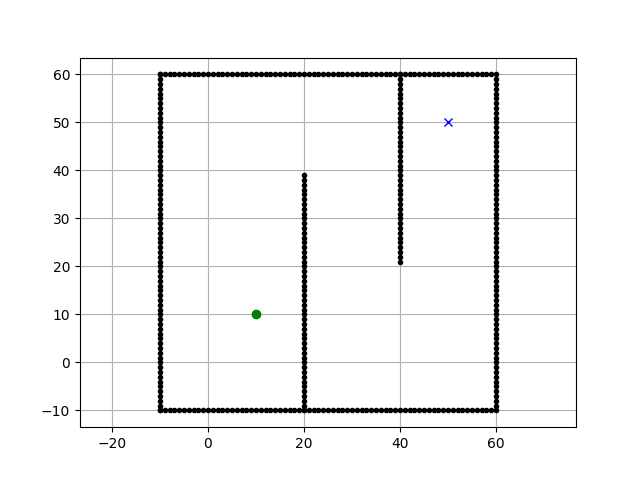

First run
MyAStarPlanner           :  Cost -   56 | Time -  12.231 ms
AStarPlanner             :  Cost -   40 | Time -  22.5986 ms
BidirectionalAStarPlanner:  Cost -   41 | Time -  19.582 ms
Dijkstra                 :  Cost -   40 | Time -  15.6628 ms
BreadthFirstSearchPlanner:  Cost -   40 | Time -  12.4142 ms
RRT Star special
Iter: 0 , number of nodes: 1
Iter: 1 , number of nodes: 2
Iter: 2 , number of nodes: 3
Iter: 3 , number of nodes: 4
Iter: 4 , number of nodes: 5
Iter: 5 , number of nodes: 6
Iter: 6 , number of nodes: 7
Iter: 7 , number of nodes: 8
Iter: 8 , number of nodes: 9
Iter: 9 , number of nodes: 10
Iter: 10 , number of nodes: 11
Iter: 11 , number of nodes: 12
Iter: 12 , number of nodes: 13
Iter: 13 , number of nodes: 14
Iter: 14 , number of nodes: 15
Iter: 15 , number of nodes: 16
Iter: 16 , number of nodes: 17
Iter: 17 , number of nodes: 18
Iter: 18 , number of nodes: 19
Iter: 19 , number of nodes: 20
Iter: 20 , number of nodes: 21
Iter: 21 , number of nodes: 22
Iter: 2

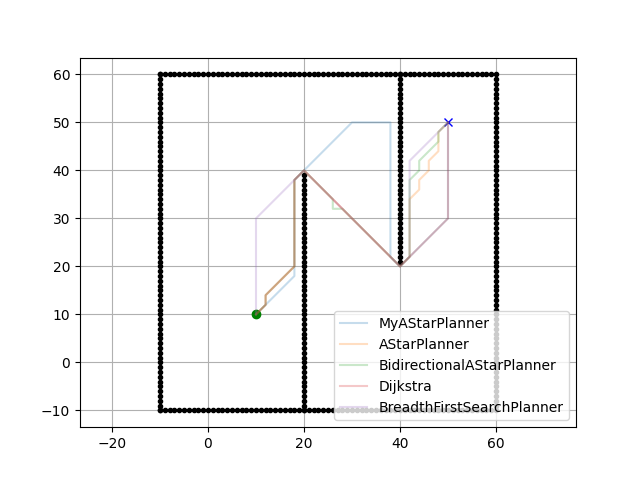

RRT Star special                  iter 1
Iter: 0 , number of nodes: 1
Iter: 1 , number of nodes: 2
Iter: 2 , number of nodes: 3
Iter: 3 , number of nodes: 4
Iter: 4 , number of nodes: 5
Iter: 5 , number of nodes: 6
Iter: 6 , number of nodes: 7
Iter: 7 , number of nodes: 8
Iter: 8 , number of nodes: 9
Iter: 9 , number of nodes: 10
Iter: 10 , number of nodes: 11
Iter: 11 , number of nodes: 12
Iter: 12 , number of nodes: 13
Iter: 13 , number of nodes: 14
Iter: 14 , number of nodes: 15
Iter: 15 , number of nodes: 15
Iter: 16 , number of nodes: 15
Iter: 17 , number of nodes: 15
Iter: 18 , number of nodes: 15
Iter: 19 , number of nodes: 16
Iter: 20 , number of nodes: 17
Iter: 21 , number of nodes: 18
Iter: 22 , number of nodes: 19
Iter: 23 , number of nodes: 20
Iter: 24 , number of nodes: 20
Iter: 25 , number of nodes: 20
Iter: 26 , number of nodes: 21
Iter: 27 , number of nodes: 22
Iter: 28 , number of nodes: 23
Iter: 29 , number of nodes: 24
Iter: 30 , number of nodes: 25
Iter: 31 , number

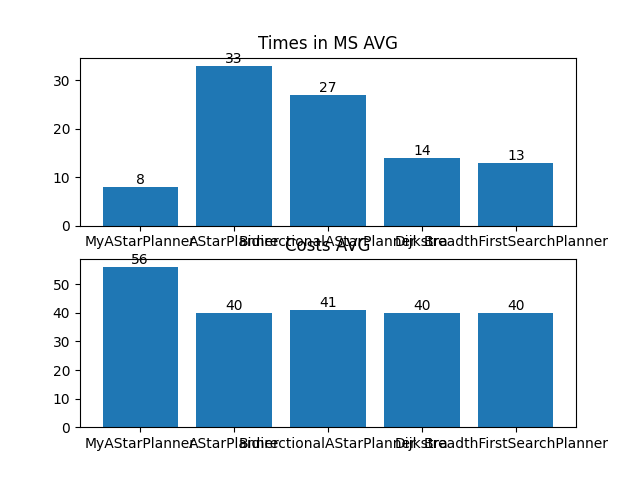

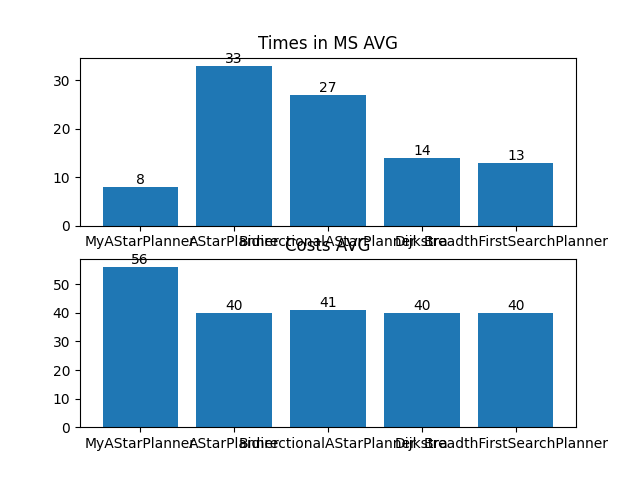

In [8]:
show_animation = False
print("Notebook" + " start!!")
from os import times
from time import perf_counter, perf_counter_ns

plt.clf()

# start and goal position
sx = 10.0  # [m]
sy = 10.0  # [m]
gx = 50.0  # [m]
gy = 50.0  # [m]
grid_size = 2  # [m]
robot_radius = 0.8  # [m]

# set obstacle positions
ox, oy = [], []
for i in range(-10, 60):
    ox.append(i)
    oy.append(-10.0)
for i in range(-10, 60):
    ox.append(60.0)
    oy.append(i)
for i in range(-10, 61):
    ox.append(i)
    oy.append(60.0)
for i in range(-10, 61):
    ox.append(-10.0)
    oy.append(i)
for i in range(-10, 40):
    ox.append(20.0)
    oy.append(i)
for i in range(0, 40):
    ox.append(40.0)
    oy.append(60.0 - i)


plt.plot(ox, oy, ".k")
plt.plot(sx, sy, "og")
plt.plot(gx, gy, "xb")
plt.grid(True)
plt.axis("equal")
plt.show()

planners = [
    MyAStarPlanner,
    AStarPlanner,
    BidirectionalAStarPlanner,
    Dijkstra,
    BreadthFirstSearchPlanner,
    RRTStar,
]

# Printing the graphs
print("First run")
for planner in planners:
    if planner.__name__ == "RRTStar":
        print("RRT Star special")

        model = planner(
            start=(sx, sy),
            goal=(gx, gy),
            obstacle_list=[[x, y, 1] for x, y in zip(ox, oy)],
            rand_area=[-2, 15],
            expand_dis=3,
            robot_radius=robot_radius,
        )
        start_time = perf_counter_ns()
        try:
            rx, ry, cost = model.planning(False)
        except TypeError:
            print(f"{planner.__name__} failed, skipping...")
            continue
        end_time = perf_counter_ns() - start_time

    else:
        model = planner(ox, oy, grid_size, robot_radius)
        start_time = perf_counter_ns()
        try:
            rx, ry, cost = model.planning(sx, sy, gx, gy)
        except TypeError:
            print(f"{planner.__name__} failed, skipping...")
            continue
        end_time = perf_counter_ns() - start_time

    print(
        f"{planner.__name__ : <25}:  Cost - {cost: 4} | Time - {end_time / 1000000: 4} ms",
    )

    plt.plot(rx, ry, label=planner.__name__, alpha=0.25)
plt.legend()
plt.show()

# Time plots
times = dict()
costs = dict()
show_animation = False
for i in range(1, 11):
    for planner in planners:
        print(f"Running {planner.__name__: <25} iter {i}", end="\r")
        if planner.__name__ == "RRTStar":
            print("RRT Star special")
            model = planner(
                start=(sx, sy),
                goal=(gx, gy),
                obstacle_list=[[x, y, 1] for x, y in zip(ox, oy)],
                rand_area=[-2, 80],
                expand_dis=1,
                robot_radius=robot_radius,
            )
            start_time = perf_counter_ns()
            try:
                rx, ry, cost = model.planning(False)
            except TypeError:
                print(f"{planner.__name__} failed, skipping...")
                continue
            end_time = perf_counter_ns() - start_time

        else:
            model = planner(ox, oy, grid_size, robot_radius)
            start_time = perf_counter_ns()
            _, _, cost = model.planning(sx, sy, gx, gy)
            end_time = perf_counter_ns() - start_time
            
            
        if times.get(planner.__name__) is None:
            times[planner.__name__] = perf_counter_ns() - start_time
            costs[planner.__name__] = cost
        else:
            times[planner.__name__] += perf_counter_ns() - start_time
            costs[planner.__name__] += cost
print()
fig, axes = plt.subplots(2)
bars = axes[0].bar(
    times.keys(), [x // 10_000_000 for x in times.values()], label="Avg time in ms"
)
axes[0].bar_label(bars)
axes[0].set_title("Times in MS AVG")

bars = axes[1].bar(
    costs.keys(), [x // 10 for x in costs.values()], label="Average cost"
)
axes[1].bar_label(bars)
axes[1].set_title("Costs AVG")
fig.show()
